****Importing the required libraries

In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from tensorflow.keras.initializers import GlorotNormal
import contractions
import re

Importing the required nltk libraries

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

When working on kaggle, this unzip code is required, but if using in local computer, it may not be required

In [6]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

****Dataset import

In [7]:
dataset = load_dataset("SetFit/sst5")

README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Print an example of the dataset, Here is the first 3 columns and the 3 corresponding labels

In [9]:
print(type(dataset['train']))
print(dataset['train'][:3])

<class 'datasets.arrow_dataset.Dataset'>
{'text': ['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'apparently reassembled from the cutting-room floor of any given daytime soap .', "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes ."], 'label': [4, 1, 1], 'label_text': ['very positive', 'negative', 'negative']}


Data preprocessing

importing lemmatization libraries

In [10]:
lemmatizer = WordNetLemmatizer()

tweet_tokenizer = TweetTokenizer()

In [11]:
def fix_contractions(text):
    return contractions.fix(text)

This is the function to handle apostrophes error

In [12]:
def fix_apostrophes(text):
    contractions = {
        "wo n't": "won't",
        "ca n't": "can't",
        "n't": "n't", 
        " 's": "'s",
        " 't": "'t",
        " 're": "'re",
        " 've": "'ve",
        " 'll": "'ll",
        " 'd": "'d",
    }

    for key, value in contractions.items():
        text = text.replace(key, value)

    text = re.sub(r"wo n't", "won't", text)

    return text

for split in ['train', 'validation', 'test']:
    dataset[split] = dataset[split].map(lambda x: {"text": fix_apostrophes(x["text"])})

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

An example of after-fixed sentences

In [13]:
for i in range(3):
    print(f"Text after Fix: {dataset['train'][i]['text']}")

Text after Fix: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Text after Fix: apparently reassembled from the cutting-room floor of any given daytime soap .
Text after Fix: they presume their audience won't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .


Preprocess_text to do preprocessing data including
+) Tokenize and remove apostrophes
+) fix the splitting of apostrophes, removing the space before apostrophe
+) lemmatize words and remove non-aphabetical tokens

In [15]:
def preprocess_text(text):
    tokens = tweet_tokenizer.tokenize(text.lower())
    print(f"Tokens after tokenization: {tokens}") 
    tokens = [token.replace(" '", "") for token in tokens]
    #print(f"Tokens after fixing apostrophes: {tokens}") 
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() or "-" in token]
    #print(f"Tokens after lemmatization and removing non-alphabetical: {tokens}")  
    return tokens

Apply the prerprocessing techniques on the train, vlidation and test set
Here we give an example of the first 3 rows of the train set after the preprocessing techniques applied

In [16]:
for split in ['train', 'validation', 'test']:
    dataset[split] = dataset[split].map(lambda x: {"text": preprocess_text(x["text"])})
for i in range(3):
    print(f"Sample {i + 1} preprocessed tokens: {dataset['train'][i]['text']}\n")

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Tokens after tokenization: ['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films']
Tokens after tokenization: ['apparently', 'reassembled', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'given', 'daytime', 'soap', '.']
Tokens after tokenization: ['they', 'presume', 'their', 'audience', "won't", 'sit', 'still', 'for', 'a', 'sociology', 'lesson', ',', 'however', 'entertainingly', 'presented', ',', 'so', 'they', 'trot', 'out', 'the', 'conventional', 'science-fiction', 'elements', 'of', 'bug-eyed', 'monsters', 'and', 'futuristic', 'women', 'in', 'skimpy', 'clothes', '.']
Tokens after tokenization: ['the', 'entire', 'movie', 'is', 'filled', 'with', 'deja', 'vu', 'moments', '.']
Tokens after tokenization: ['this', 'is', 'a', 'visually', 'stunning', 'rumination', 'on', 'love', ',', 'memory', ',', 'history', 'and', 'the', 'war', 'between', 'art', 'and', 'commerce', '.']
Tokens after token

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Tokens after tokenization: ['in', 'his', 'first', 'stab', 'at', 'the', 'form', ',', 'jacquot', 'takes', 'a', 'slightly', 'anarchic', 'approach', 'that', 'works', 'only', 'sporadically', '.']
Tokens after tokenization: ['one', 'long', 'string', 'of', 'cliches', '.']
Tokens after tokenization: ['if', "you've", 'ever', 'entertained', 'the', 'notion', 'of', 'doing', 'what', 'the', 'title', 'of', 'this', 'film', 'implies', ',', 'what', 'sex', 'with', 'strangers', 'actually', 'shows', 'may', 'put', 'you', 'off', 'the', 'idea', 'forever', '.']
Tokens after tokenization: ['k', '-', '19', 'exploits', 'our', 'substantial', 'collective', 'fear', 'of', 'nuclear', 'holocaust', 'to', 'generate', 'cheap', 'hollywood', 'tension', '.']
Tokens after tokenization: ["it's", 'played', 'in', 'the', 'most', 'straight-faced', 'fashion', ',', 'with', 'little', 'humor', 'to', 'lighten', 'things', 'up', '.']
Tokens after tokenization: ['there', 'is', 'a', 'fabric', 'of', 'complex', 'ideas', 'here', ',', 'and', '

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

Tokens after tokenization: ['no', 'movement', ',', 'no', 'yuks', ',', 'not', 'much', 'of', 'anything', '.']
Tokens after tokenization: ['a', 'gob', 'of', 'drivel', 'so', 'sickly', 'sweet', ',', 'even', 'the', 'eager', 'consumers', 'of', "moore's", 'pasteurized', 'ditties', 'will', 'retch', 'it', 'up', 'like', 'rancid', 'crème', 'brûlée', '.']
Tokens after tokenization: ['`', 'how', 'many', 'more', 'voyages', 'can', 'this', 'limping', 'but', 'dearly-loved', 'franchise', 'survive', '?', "'"]
Tokens after tokenization: ['so', 'relentlessly', 'wholesome', 'it', 'made', 'me', 'want', 'to', 'swipe', 'something', '.']
Tokens after tokenization: ['gangs', 'of', 'new', 'york', 'is', 'an', 'unapologetic', 'mess', ',', 'whose', 'only', 'saving', 'grace', 'is', 'that', 'it', 'ends', 'by', 'blowing', 'just', 'about', 'everything', 'up', '.']
Tokens after tokenization: ['we', 'never', 'really', 'feel', 'involved', 'with', 'the', 'story', ',', 'as', 'all', 'of', 'its', 'ideas', 'remain', 'just', 'tha

In [17]:
for i in range(3):
    print(f"Sample {i + 1} preprocessed tokens: {' '.join(dataset['train'][i]['text'])}\n")

Sample 1 preprocessed tokens: a stirring funny and finally transporting re-imagining of beauty and the beast and horror film

Sample 2 preprocessed tokens: apparently reassembled from the cutting-room floor of any given daytime soap

Sample 3 preprocessed tokens: they presume their audience sit still for a sociology lesson however entertainingly presented so they trot out the conventional science-fiction element of bug-eyed monster and futuristic woman in skimpy clothes



In [18]:
train_texts = [' '.join(text) for text in dataset['train']['text']]
val_texts = [' '.join(text) for text in dataset['validation']['text']]
test_texts = [' '.join(text) for text in dataset['test']['text']]

Tokenization

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
vocab_size = len(tokenizer.word_index) + 1

We use the 95th percentile as the max_length value

In [21]:
#import numpy as np
#all_lengths = [len(text.split()) for text in train_texts]
#max_length = int(np.percentile(all_lengths, 95))
#print(f"Chosen max_length (95th percentile): {max_length}")
max_length = 64
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_length)
val_sequences = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_length)
test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_length)

In [22]:
embedding_dim = 300
custom_word2vec = Word2Vec(sentences=[text.split() for text in train_texts], vector_size=embedding_dim, window=5, min_count=2, workers=4)

# Prepare Embedding Matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in custom_word2vec.wv:
        embedding_matrix[i] = custom_word2vec.wv[word]

In [18]:
import pickle

tokenizer_path = 'tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

In [19]:
embedding_matrix_path = 'embedding_matrix.npy'
np.save(embedding_matrix_path, embedding_matrix)

In [20]:
import pickle
import numpy as np

# Load the tokenizer from /kaggle/working/
tokenizer_path = '/kaggle/working/tokenizer.pkl'
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

print("Tokenizer loaded successfully.")


Tokenizer loaded successfully.


In [22]:
# Load the embedding matrix from /kaggle/working/
embedding_matrix_path = '/kaggle/working/embedding_matrix.npy'
embedding_matrix = np.load(embedding_matrix_path)

print("Embedding matrix loaded successfully.")

Embedding matrix loaded successfully.


In [44]:
def create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = GlorotNormal()  # Or use GlorotUniform()

    inputs = Input(shape=(max_length,))
    
    # Using the embedding matrix, ensure it's not trainable
    x = Embedding(input_dim=vocab_size, 
                  output_dim=embedding_dim, 
                  weights=[embedding_matrix], 
                  input_length=max_length, 
                  trainable=False)(inputs)
    
    # Apply Conv1D with Xavier initialization for weights
    x = Conv1D(filters=filters, 
               kernel_size=kernel_size, 
               activation='relu', 
               kernel_initializer=xavier_initializer,  # Xavier initialization
               kernel_regularizer=l2(0.01))(x)
    
    x = GlobalMaxPooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, 
              activation='relu', 
              kernel_initializer=xavier_initializer,  # Xavier initialization
              kernel_regularizer=l2(0.01))(x)
    
    x = Dropout(dropout_rate)(x)
    outputs = Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [33]:
# Convert labels to categorical
train_labels = np.array(dataset["train"]["label"])
val_labels = np.array(dataset["validation"]["label"])
test_labels = np.array(dataset["test"]["label"])
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=5)
val_labels_categorical = tf.keras.utils.to_categorical(val_labels, num_classes=5)

In [42]:
# Create the model
model = create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate)

NameError: name 'filters' is not defined

In [39]:
# Create the model
model = create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate)

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

NameError: name 'filters' is not defined

In [ ]:
# Train the model
history = model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  # Use the class weights dictionary here
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)
# Evaluate on the test set
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2405 - loss: 6.6630 - val_accuracy: 0.2625 - val_loss: 4.4990 - learning_rate: 1.2000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2583 - loss: 5.2900 - val_accuracy: 0.2625 - val_loss: 3.5674 - learning_rate: 1.2000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2631 - loss: 4.4942 - val_accuracy: 0.2625 - val_loss: 2.9870 - learning_rate: 1.2000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2639 - loss: 3.9881 - val_accuracy: 0.2625 - val_loss: 2.6418 - learning_rate: 1.2000e-04
Epoch 5/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2600 - loss: 3.6522 - val_accuracy: 0.2625 - val_loss: 2.3513 - learning_rate: 1.2000e-04
Epoch 6/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2551 - loss: 3.3924 - val_accuracy: 0.2625 - val_loss: 2.2025 - learning_rate: 1.2000e-04
Epoch 7/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2595 - lo

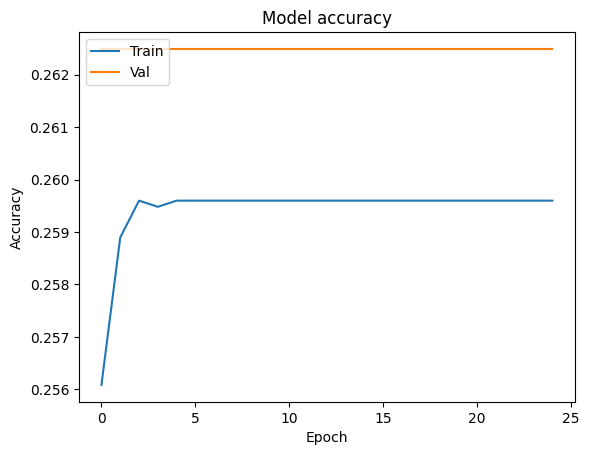

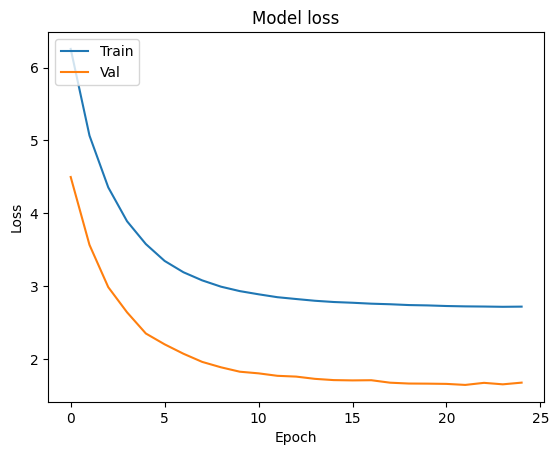

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.29      1.00      0.45       633
           2       0.00      0.00      0.00       389
           3       0.00      0.00      0.00       510
           4       0.00      0.00      0.00       399

    accuracy                           0.29      2210
   macro avg       0.06      0.20      0.09      2210
weighted avg       0.08      0.29      0.13      2210



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


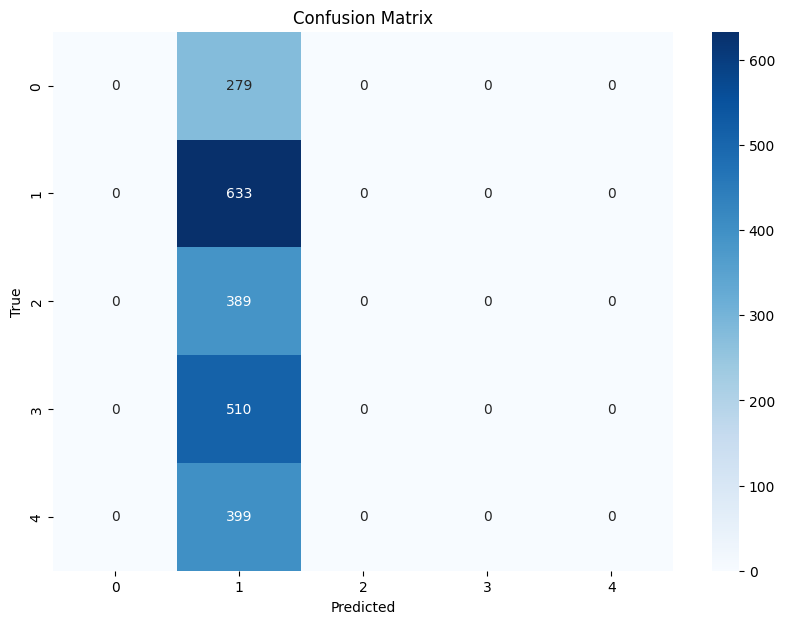

In [38]:
# Train the model
history = model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  # Use the class weights dictionary here
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)
# Evaluate on the test set
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"

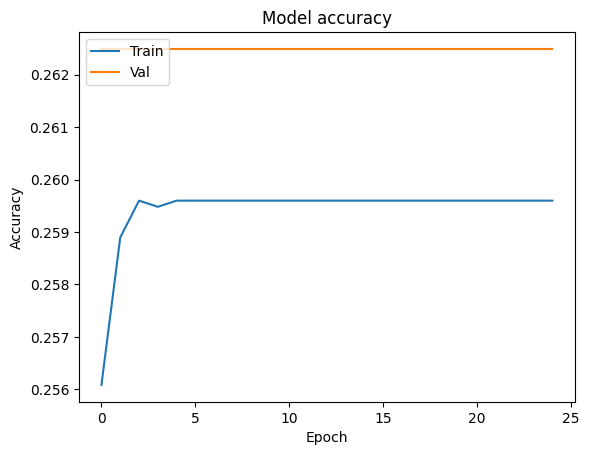

In [41]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


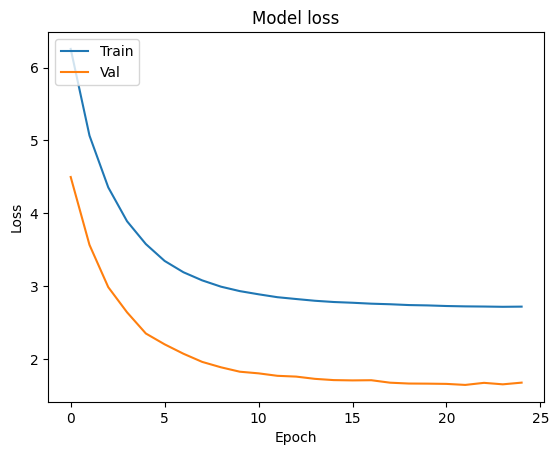

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.29      1.00      0.45       633
           2       0.00      0.00      0.00       389
           3       0.00      0.00      0.00       510
           4       0.00      0.00      0.00       399

    accuracy                           0.29      2210
   macro avg       0.06      0.20      0.09      2210
weighted avg       0.08      0.29      0.13      2210



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


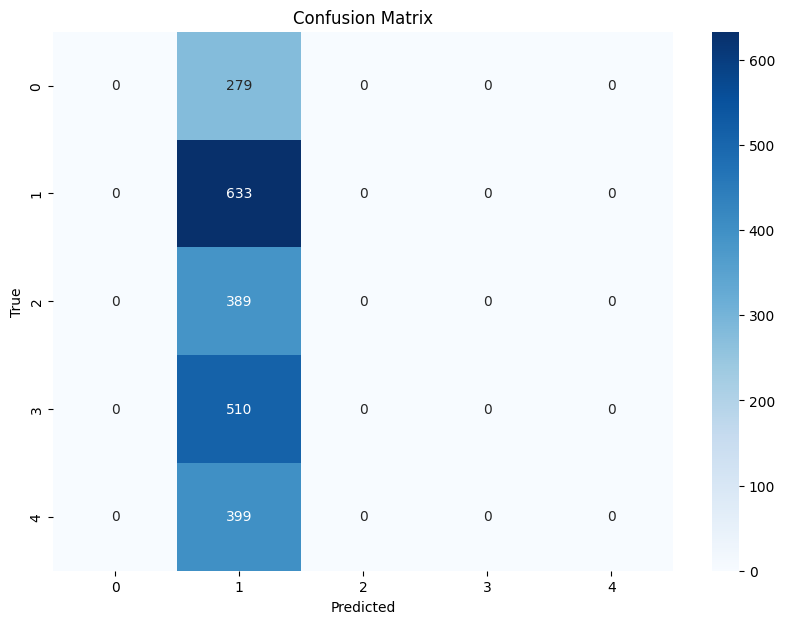

In [42]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels on the test set
test_predictions = model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Classification report
print(classification_report(test_labels, test_predictions_classes))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

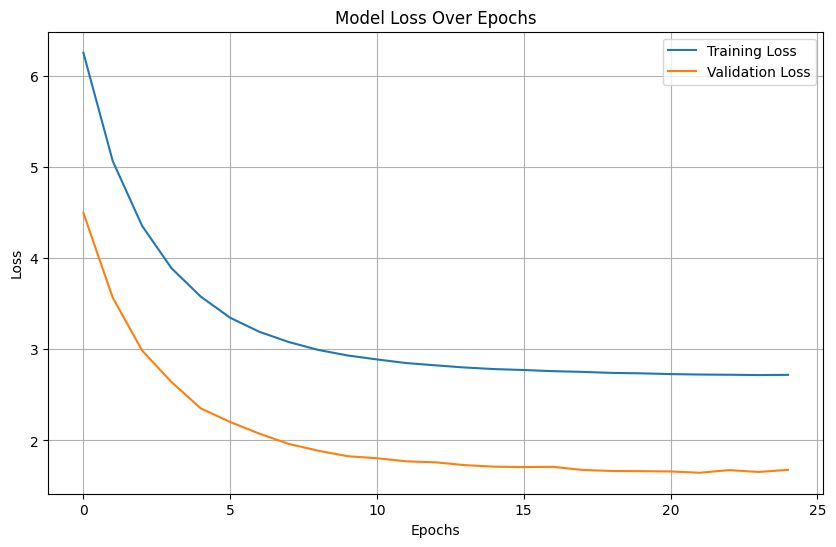

In [43]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


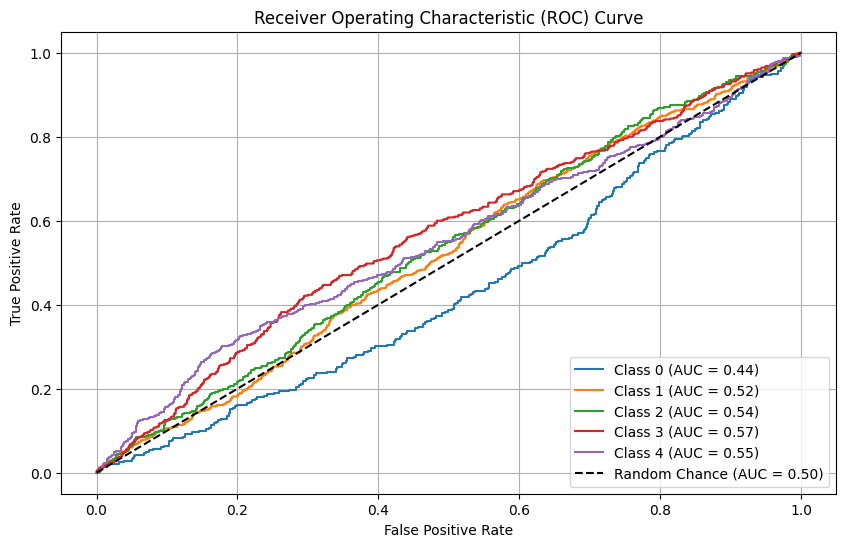

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get predicted probabilities (for each class)
y_pred_prob = model.predict(test_sequences)

# Binarize the labels for multi-class ROC (convert labels into one-hot encoded format)
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))

# Plot each class ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line (diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

# Final plot settings
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Hyperparameter tuning

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense,
    Dropout, Input, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import os
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Because i have hyperparameter tuned couple times so i need this one to restart the process

In [ ]:
# Clear the previous tuning results (optional: only if you want a fresh start)
tuning_directory = "hyperparameter_tuning"
if os.path.exists(tuning_directory):
    import shutil
    shutil.rmtree(tuning_directory)

In [ ]:
# Define the model-building function for tuning
def build_model(hp):
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )
    
    inputs = Input(shape=(max_length,))
    x = embedding_layer(inputs)

    # Stack of Conv1D layers with tunable filters, kernel size, and activation
    for i in range(hp.Int("conv_layers", min_value=1, max_value=3, step=1)):
        x_residual = x  # Save input for residual connection
        x = Conv1D(
            filters=hp.Int(f"filters_{i}", min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5, 7]),
            activation="relu",
            padding="same",
            kernel_regularizer=l2(0.01)
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float(f"dropout_rate_{i}", min_value=0.2, max_value=0.5, step=0.1))(x)
        
        # Add residual connection if filter dimensions match
        if x.shape[-1] == x_residual.shape[-1]:
            x = tf.keras.layers.add([x, x_residual])

    # Combine Global Max Pooling and Global Average Pooling
    x_maxpool = GlobalMaxPooling1D()(x)
    x_avgpool = GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Concatenate()([x_maxpool, x_avgpool])

    # Dense layer with tunable units
    x = Dense(
        units=hp.Int("dense_units", min_value=128, max_value=256, step=64),
        activation="relu",
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(hp.Float("dense_dropout_rate", min_value=0.2, max_value=0.5, step=0.1))(x)

    # Output layer
    outputs = Dense(5, activation="softmax")(x)

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model

In [ ]:
# Initialize the Keras Tuner Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",  # Use validation accuracy as the optimization objective
    max_epochs=10,  # Each trial runs for up to 10 epochs
    factor=3,  # Halve resources every 3 epochs
    directory="hyperparameter_tuning",
    project_name="cnn_tuning_no_lstm"
)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Start the hyperparameter search
tuner.search(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
import shutil
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Use the best hyperparameters from the tuning process
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Conv Layers: {best_hps.get('conv_layers')}")
print(f"Filters for Layer 0: {best_hps.get('filters_0')}")
print(f"Kernel Size for Layer 0: {best_hps.get('kernel_size_0')}")
print(f"Dropout Rate for Layer 0: {best_hps.get('dropout_rate_0')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dense Dropout Rate: {best_hps.get('dense_dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Filters for Layer 1: {best_hps.get('filters_1')}")
print(f"Kernel Size for Layer 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout Rate for Layer 1: {best_hps.get('dropout_rate_1')}")
print(f"Filters for Layer 2: {best_hps.get('filters_2')}")
print(f"Kernel Size for Layer 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout Rate for Layer 2: {best_hps.get('dropout_rate_2')}")

In [36]:
def build_final_model(hp):
    inputs = Input(shape=(max_length,))
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )(inputs)

    # Add Conv1D layers based on the best hyperparameters
    for i in range(best_hps.get('conv_layers')):
        filters = best_hps.get(f'filters_{i}')
        kernel_size = best_hps.get(f'kernel_size_{i}')
        dropout_rate = best_hps.get(f'dropout_rate_{i}')
        
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = Dropout(dropout_rate)(x)

    # Apply global max pooling
    x = GlobalMaxPooling1D()(x)

    # Dense layer with best hyperparameters
    x = Dense(units=best_hps.get('dense_units'), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(best_hps.get('dense_dropout_rate'))(x)

    # Output layer
    outputs = Dense(5, activation='softmax')(x)

    # Build and compile model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model

In [37]:
model = create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate)

NameError: name 'filters' is not defined

In [ ]:
final_model = build_final_model(best_hps)

In [ ]:
# Define early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the final model with the full dataset
history = final_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,  # Train for 50 epochs as the final model
    batch_size=32,
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=[early_stopping, lr_scheduler]  # Callbacks for training
)

# Evaluate the final model on the test set
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = final_model.evaluate(test_sequences, test_labels_categorical)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

# Save the final model in .h5 format
final_model.save("checkpoints/final_cnn_model.h5", save_format="h5")

# Compress the checkpoints folder into a zip file
shutil.make_archive(base_name="/kaggle/working/checkpoints", format="zip", root_dir="checkpoints")


In [ ]:
class_weights = {
    0: 1.5,  # Increase weight for underrepresented classes
    1: 2.0,
    2: 2.5,
    3: 1.0,  # Neutral class has smaller weight to prevent overfitting
    4: 2.0
}

# Compile the model with a lower learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor the validation loss
    patience=100,  # Increase patience to allow for longer training
    restore_best_weights=True
)

# Re-compile the model with the same learning rate and class weights
final_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

In [ ]:
history = final_model.fit(
    train_sequences, 
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,  # Train for 50 epochs, or adjust based on training progress
    batch_size=32,
    class_weight=class_weights,  # Adjusted class weights
    callbacks=[early_stopping, lr_scheduler]  # Use early stopping and learning rate scheduler
)

# Reevaluate after training
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = final_model.evaluate(test_sequences, test_labels_categorical)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

test_predictions = final_model.predict(test_sequences)

# Binarize the true labels (for multi-class classification)
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Training')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy During Training')

plt.tight_layout()
plt.show()

In [ ]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):  # 5 classes in the SST-5 dataset
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for all classes
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

# Compute confusion matrix
test_predictions_classes = test_predictions.argmax(axis=-1)
conf_matrix = confusion_matrix(test_labels, test_predictions_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
print(classification_report(test_labels, test_predictions_classes))


In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Create the path for saving the model and weights (using .keras extension)
model_save_path = "/kaggle/working/final_model.keras"

# Define early stopping with increased patience
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor the validation loss
    patience=100,  # Increase patience to allow for longer training
    restore_best_weights=True
)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

# Define ModelCheckpoint callback to save the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    model_save_path,  # Path where the best model will be saved
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save the model only when the validation loss improves
    save_weights_only=False,  # Save the entire model (architecture + weights)
    mode="min",  # Minimize the validation loss
    verbose=1
)

# Re-compile the model with the same learning rate and class weights
final_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# Train the model again with adjusted class weights, increased patience for early stopping, and checkpoint callback
history = final_model.fit(
    train_sequences, 
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,  # Train for 50 epochs, or adjust based on training progress
    batch_size=32,
    class_weight=class_weights,  # Adjusted class weights
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback]  # Use early stopping, learning rate scheduler, and model checkpoint
)

# After training, load the best saved model with weights
best_model = tf.keras.models.load_model(model_save_path)

# Reevaluate the best model on the test data
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

# Save the final model and weights again after evaluation (if needed)
final_model.save(model_save_path, save_format="keras")


In [ ]:
import shutil

# Compress the directory
shutil.make_archive(base_name="/kaggle/working/checkpoints", format="zip", root_dir="checkpoints")